<a href="https://colab.research.google.com/github/jlzhang93/relax_challenge/blob/master/relax_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/Data\ Science\ Practice

/content/drive/My Drive/Data Science Practice


In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

In [0]:
users = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Text(0.5, 1.0, 'Number of users belong to certain organization')

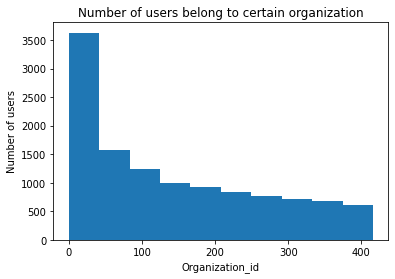

In [7]:
plt.hist(users.org_id)
plt.xlabel('Organization_id')
plt.ylabel('Number of users')
plt.title('Number of users belong to certain organization')

In [8]:
users.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

There are 417 organization for all users. The organization with most users is No. 0 with 319 users.

Text(0.5, 1.0, 'Distribution of users per creation source')

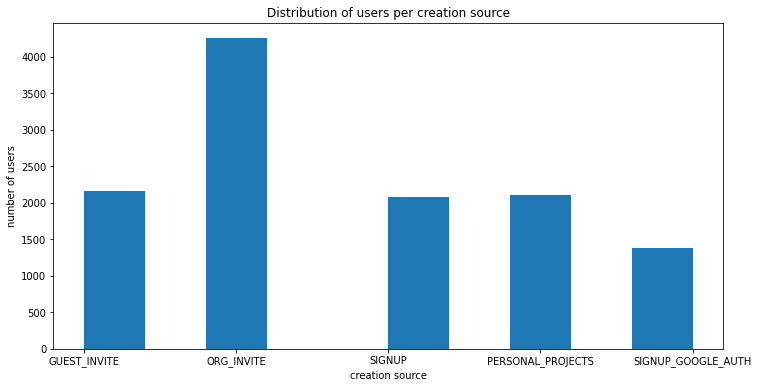

In [9]:
plt.figure(figsize=(12, 6))
plt.hist(users.creation_source)
plt.xlabel('creation source')
plt.ylabel('number of users')
plt.title('Distribution of users per creation source')

There are 5 kinds of users with regard to creation sources. The most popular creation source is org_invite and the least common is signup_google_auth.

In [0]:
users['email'] = users.email.str.split('@').str[1].str.split('.').str[0].astype(
    'category')

`email` feature is replaced by the email domain.

In [11]:
users.email.value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
              ... 
rmlsj            1
rnlqw            1
rnoef            1
rosyq            1
abdnf            1
Name: email, Length: 1184, dtype: int64

There are 1184 kinds of email domain and the most common kind is from gmail.com, followed by yahoo.com.

In [0]:
users['creation_time'] = pd.to_datetime(users.creation_time)
users['creation_year'] = users.creation_time.dt.year
users['creation_month'] = users.creation_time.dt.month
users['creation_day'] = users.creation_time.dt.day
users['creation_hour'] = users.creation_time.dt.hour

Features are generated according to what year/month/day/hour of the account is generated.

In [14]:
print('There are {} usere out of 12000 that are on the regular marketing \
drip'.format(users.enabled_for_marketing_drip.sum()))

There are 1792 usere out of 12000 that are on the regular marketing drip


In [15]:
print('There are {} usere out of 12000 that have opted into receiving \
marketing emails'.format(users.opted_in_to_mailing_list.sum()))

There are 2994 usere out of 12000 that have opted into receiving marketing emails


In [16]:
users[users.invited_by_user_id == users.object_id]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_year,creation_month,creation_day,creation_hour
22,23,2012-08-17 08:30:27,Souza Alice,gustr,ORG_INVITE,1.345279e+09,1,0,6,23.0,2012,8,17,8
49,50,2012-06-03 11:02:08,Oliveira Gabrielly,gmail,GUEST_INVITE,1.350990e+09,0,0,61,50.0,2012,6,3,11
120,121,2013-01-03 23:57:39,Toft Dennis,cuvox,GUEST_INVITE,1.357257e+09,1,0,402,121.0,2013,1,3,23
177,178,2012-06-08 14:44:58,Brauer Daniela,gmail,ORG_INVITE,1.339167e+09,0,0,415,178.0,2012,6,8,14
192,193,2012-10-30 04:15:49,Rocha Erick,jourrapide,ORG_INVITE,1.351571e+09,1,0,122,193.0,2012,10,30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767,11768,2012-10-10 12:02:31,White Robert,cuvox,ORG_INVITE,NaN,0,0,38,11768.0,2012,10,10,12
11773,11774,2012-07-10 10:01:09,Toft Louise,rimoj,ORG_INVITE,1.342346e+09,0,0,3,11774.0,2012,7,10,10
11794,11795,2012-10-25 14:15:03,König Frank,cuvox,ORG_INVITE,1.351175e+09,0,0,153,11795.0,2012,10,25,14
11803,11804,2012-06-18 09:20:44,Lund Jens,gmail,GUEST_INVITE,NaN,0,0,26,11804.0,2012,6,18,9


222 users are invited by themselves to join. This does not seem right.

In [0]:
last = users.copy().loc[~users.last_session_creation_time.isnull()]

In [0]:
last['creation'] = (pd.to_datetime(last.creation_time)- 
                    datetime(1970, 1, 1, 0, 0, 0)).dt.total_seconds()

In [19]:
(last.creation == last.last_session_creation_time).sum()

3027

Missing values consist of  approximately 26% in `last_session_creation_time`. After selecting all 8823 rows with both `creation_time` and `last_session_creation_time` (as DataFrame`last`) and converting `creation_time` from `datetime` object to `int` as timestamp, there are 3027 rows that have the same `creation_time` and `last_session_creation_time`. Therefore, it is inappropriate to fill in the missing values of `last_session_creation_time` with `creation_time`.

In [20]:
engagement = pd.read_csv('takehome_user_engagement.csv', encoding="ISO-8859-1",
                         parse_dates=['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [21]:
engagement['time_stamp'] = engagement['time_stamp'].dt.date
s = engagement.groupby(['user_id', 'time_stamp']).visited.count()
s.value_counts()

1    207917
Name: visited, dtype: int64

This shows that any user logs into the product at most once per day.

In [0]:
engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp)

sort = engagement.set_index('time_stamp').groupby(
    'user_id').resample('7d').visited.count()

adopted_id = sort[sort >= 3].index.get_level_values(0).unique()

`Adopted_id` includes ids of all users  that have logged into the product on three separate days in at least 7-day period 

In [23]:
print('There are {} users out of 12000 that are adopted users.'.format(
    len(adopted_id)))

There are 1472 users out of 12000 that are adopted users.


Therefore, this data is imbalanced.

In [0]:
for row in users.itertuples():
    if row.Index in adopted_id:
        users.loc[row.Index, 'adopted'] = 1
    else:
        users.loc[row.Index, 'adopted'] = 0

The target is added as `adopted`. If the id of a user is in `adopted_id`, then `adopted` is marked as 1, or it is marked as 0. 

In [0]:
missing = users.copy()[users.last_session_creation_time.isnull()]

In [29]:
np.intersect1d(engagement.user_id.unique(), missing.object_id.unique())

array([], dtype=int64)

The data in the `engagement.csv` can't be used to fill the missing values of `last_session_creation_time` in `users.csv` as the accounts with missing information are not documented for engagement. Therefore, there is no proper way to fill in the missing values of `last_session_creation_time` and those rows with missing values are dropped. 

In [0]:
users = users.drop(users[users.last_session_creation_time.isnull()].index)

In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   category      
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          4776 non-null   float64       
 10  creation_year               8823 non-null   int64         
 11  creation_month              8823 non-null   int64      

More than half of the `invited_by_user_id` values are missing, and some users are invited by themselves. This feature does not seem to be documented correctly and therefore will be dropped.

In [0]:
users = users.drop('invited_by_user_id', axis=1)

In [33]:
users.adopted.sum()

1064.0

After dropping the rows with missing values, the dataset is still imbalanced because 1064 out of 8823 accounts are adopted users.

In [0]:
users['last_session_creation_time'] = pd.to_datetime(users.last_session_creation_time,
                                                     unit='s')

In [0]:
users['duration'] = (users['last_session_creation_time'] - 
                     users['creation_time']).dt.days

The time between signup date and the last login date is saved as a new feature `duration`

In [36]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   category      
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   creation_year               8823 non-null   int64         
 10  creation_month              8823 non-null   int64         
 11  creation_day                8823 non-null   int64      

In [0]:
users.drop(['name', 'object_id', 'creation_time', 'last_session_creation_time'],
           axis=1, inplace=True)

In [0]:
y = users['adopted'].astype(int)
X = users.drop(['adopted'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()
X = X.apply(le.fit_transform)

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25,
                                                random_state=7)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

K nearest neighbor is used as a benchmark model.

In [0]:
ypred = knn.predict(Xtest)

In [53]:
print(classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2175
           1       0.02      0.16      0.03        31

    accuracy                           0.87      2206
   macro avg       0.50      0.52      0.48      2206
weighted avg       0.97      0.87      0.92      2206



In [54]:
print(roc_auc_score(ypred, ytest))

0.5222543566926214


We can see that the model does not do a good job predicting adopted users.

In [46]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The oversampling can be fixed by generating new samples in the non-adopted user class by randomly sampling with replacement.

In [0]:
Xtrain_re, Xtest_re, ytrain_re, ytest_re = train_test_split(X_resampled, 
                                                            y_resampled,
                                                            test_size = 0.25,
                                                            random_state=7)

In [48]:
knn.fit(Xtrain_re, ytrain_re)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
ypred_re = knn.predict(Xtest_re)

In [50]:
print(classification_report(ypred_re, ytest_re))

              precision    recall  f1-score   support

           0       0.63      0.91      0.75      1337
           1       0.94      0.72      0.82      2543

    accuracy                           0.79      3880
   macro avg       0.78      0.82      0.78      3880
weighted avg       0.83      0.79      0.79      3880



In [56]:
print(roc_auc_score(ypred_re, ytest_re))

0.81522759913188


After more samples are generated for non-adopted user class, the knn model is more accurate. 

In [57]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(Xtrain_re, ytrain_re)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [0]:
ypred_re = clf.predict(Xtest_re)

In [59]:
print(classification_report(ypred_re, ytest_re))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1607
           1       1.00      0.86      0.93      2273

    accuracy                           0.92      3880
   macro avg       0.92      0.93      0.92      3880
weighted avg       0.93      0.92      0.92      3880



In [60]:
print(roc_auc_score(ypred_re, ytest_re))

0.9314058790854245


The decision tree model is doing a better job.

In [0]:
result = pd.DataFrame(clf.tree_.compute_feature_importances(), index=X.columns,
                      columns=['feature_importance']).sort_values('feature_importance')

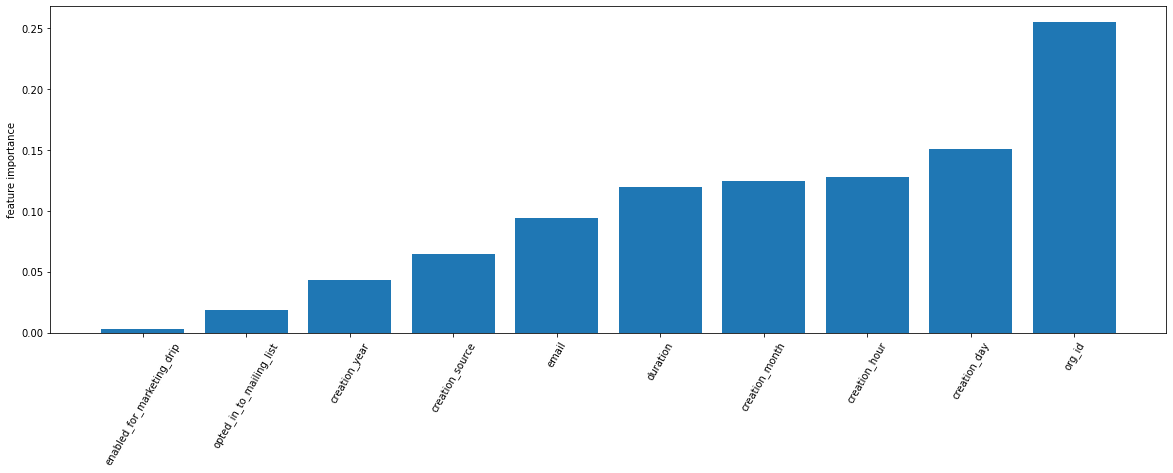

In [62]:
plt.figure(figsize=(20, 6))
plt.bar(result.index, result.feature_importance)
plt.xticks(rotation=60)
plt.ylabel('feature importance')
plt.show()

The organization that an user belongs to greatly affects wheather this user is `adopted` or not. Surprisingly whether users opt into receiving marketing email or are on the regular email drip does not directly relate to whether they are adopted users. 
<br>
<br>
It would be helpful to fix the data by finding out what happens to the users whose last logins were missing and why the `invited_by_user_id` is missing for 50% users. And it would be very helpful to collect data on those who are not adopted users to avoid imbalanced datasets. Hyperparameter tuning is necessary to improve models too.



In [63]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier()
cl.fit(Xtrain_re, ytrain_re)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
ypred_re = cl.predict(Xtest_re)

In [65]:
print(classification_report(ypred_re, ytest_re))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1896
           1       1.00      0.99      0.99      1984

    accuracy                           0.99      3880
   macro avg       0.99      0.99      0.99      3880
weighted avg       0.99      0.99      0.99      3880



The random forest model does a very good job predicting both classes.

In [0]:
importance = pd.DataFrame(cl.feature_importances_, index=X.columns, 
             columns=['feature_importance']).sort_values('feature_importance')

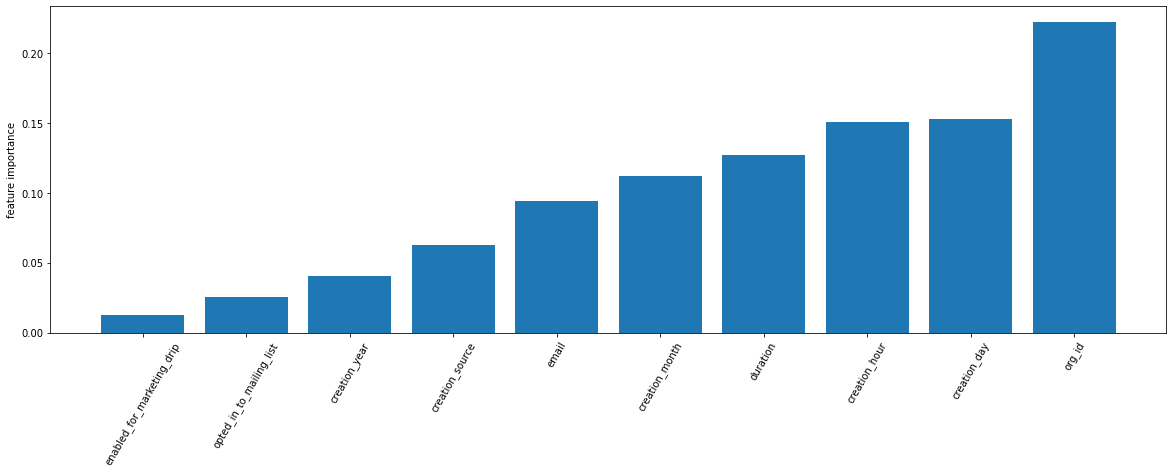

In [67]:
plt.figure(figsize=(20, 6))
plt.bar(importance.index, importance.feature_importance)
plt.xticks(rotation=60)
plt.ylabel('feature importance')
plt.show()